install torch with cuda

https://pytorch.org/get-started/locally/

https://visualstudio.microsoft.com/pt-br/visual-cpp-build-tools/

In [1]:
# import torch
# torch.cuda.is_available()

# import os
# print(os.environ.get('CUDA_PATH'))

# conda install -c conda-forge cudatoolkit-dev -y

# export CUDA_HOME=/path/to/cuda-11.3/

In [20]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import torch
from PIL import Image
import numpy as np
from torchvision.ops import box_convert
import cv2

In [3]:
model = load_model("../../GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "../../GroundingDINO/weights/groundingdino_swint_ogc.pth")

c:\Users\jac\anaconda3\envs\dino\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [4]:
IMAGE_PATH = "imagens/01.jpg"
TEXT_PROMPT = "car"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

In [5]:
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

c:\Users\jac\anaconda3\envs\dino\Lib\site-packages\transformers\modeling_utils.py:942: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\jac\anaconda3\envs\dino\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\jac\anaconda3\envs\dino\Lib\site-packages\torch\utils\checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [6]:
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
cv2.imwrite("resultados/annotated_image.jpg", annotated_frame)

True

In [21]:
def generate_masks_with_grounding(image_source, boxes):
    h, w, _ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
    boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    mask = np.zeros_like(image_source)
    for box in boxes_xyxy:
        x0, y0, x1, y1 = box
        mask[int(y0):int(y1), int(x0):int(x1), :] = 255
    return mask

In [22]:
image_mask = generate_masks_with_grounding(image_source, boxes)

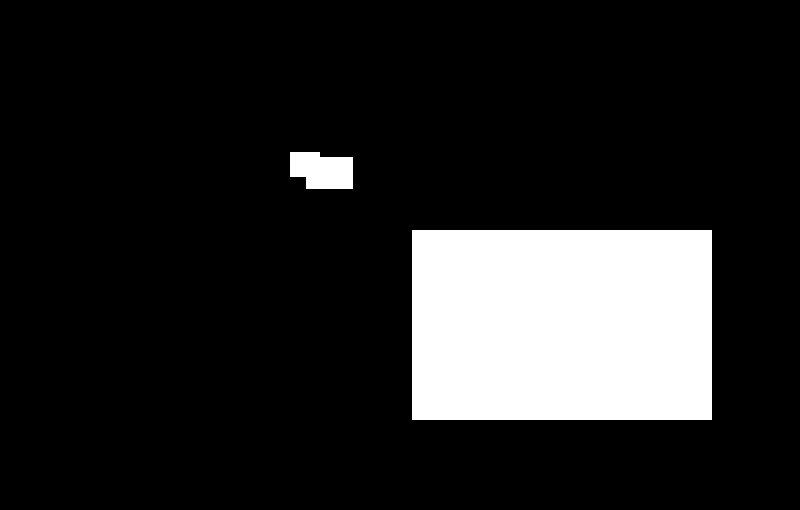

In [23]:
Image.fromarray(image_mask)